# GO_cluster

In [66]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import squareform

In [67]:
def check_distance_matrix(distance_matrix):
    is_square = distance_matrix.shape[0] == distance_matrix.shape[1]
    print("Matrix is square:", is_square)

    diagonal_elements = np.diag(distance_matrix)
    are_diagonals_zero = np.all(diagonal_elements == 0)
    print("All diagonal elements are zero:", are_diagonals_zero)

    nan_count = distance_matrix.isna().sum().sum()
    print("Number of NaN values in the matrix:", nan_count)

In [68]:
def hierarchical_clustering(distance_matrix, range_min=2, range_max=10):
    condensed_matrix = squareform(distance_matrix, force="tovector", checks=False)
    Z = linkage(condensed_matrix, method="ward")
    range_n_clusters = range(range_min, range_max + 1)
    silhouette_avg = []

    for n_clusters in range_n_clusters:
        labels = fcluster(Z, n_clusters, criterion="maxclust")
        silhouette_avg.append(
            silhouette_score(distance_matrix, labels, metric="precomputed")
        )

    best_n_clusters = range_n_clusters[np.argmax(silhouette_avg)]
    print("Best number of clusters:", best_n_clusters)

    # Create a figure with two subplots: one for the dendrogram and one for the silhouette scores
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

    # Plot dendrogram on the left
    dendrogram(Z, ax=ax1)
    ax1.set_title("Dendrogram")
    ax1.set_xlabel("Sample index")
    ax1.set_ylabel("Distance")

    # Plot silhouette scores on the right
    ax2.plot(range_n_clusters, silhouette_avg, marker="o")
    ax2.set_title("Silhouette Score for Various Number of Clusters")
    ax2.set_xlabel("Number of Clusters")
    ax2.set_ylabel("Average Silhouette Score")
    ax2.set_xticks(range(2, range_max))

    plt.tight_layout()
    plt.show()

    labels = fcluster(Z, best_n_clusters, criterion="maxclust")
    dis_col = distance_matrix
    gene_names = dis_col.columns
    gene_clusters = pd.DataFrame({"gene": gene_names, "cluster": labels})
    return gene_clusters

In [69]:
base_path = "../breast/result/GDC_breast_tissue_450k/train80/"

dbeta_path = base_path + "dbeta_GSE243529_TSS_0.15.csv"
dm_bp = base_path + "distance_matrix_bp_GSE243529_TSS_0.15.csv"
dm_cc = base_path + "distance_matrix_cc_GSE243529_TSS_0.15.csv"
dm_mf = base_path + "distance_matrix_mf_GSE243529_TSS_0.15.csv"
terms_count_path = base_path + "terms_count.csv"

weighted_average_output = base_path + "dbeta_GSE243529_TSS_0.15_weighted.csv"
simple_average_output = base_path + "dbeta_GSE243529_TSS_0.15_simple.csv"
consensus_output = base_path + "dbeta_GSE243529_TSS_0.15_consensus.csv"

In [70]:
dbeta = pd.read_csv(dbeta_path, index_col=0)
distance_matrix_bp = pd.read_csv(dm_bp, index_col=0)
distance_matrix_cc = pd.read_csv(dm_cc, index_col=0)
distance_matrix_mf = pd.read_csv(dm_mf, index_col=0)
terms_count = pd.read_csv(terms_count_path, index_col=0)

In [71]:
# replace NaN with 0
distance_matrix_bp = distance_matrix_bp.fillna(0)
distance_matrix_cc = distance_matrix_cc.fillna(0)
distance_matrix_mf = distance_matrix_mf.fillna(0)

In [72]:
# reindex distance matrix
index_bp = distance_matrix_bp.index
index_cc = distance_matrix_cc.index
index_mf = distance_matrix_mf.index
index = index_bp.union(index_cc).union(index_mf)
distance_matrix_bp_ = distance_matrix_bp.reindex(index=index, columns=index)
distance_matrix_cc_ = distance_matrix_cc.reindex(index=index, columns=index)
distance_matrix_mf_ = distance_matrix_mf.reindex(index=index, columns=index)

In [73]:
# make a array of distance matrix for each ontology
distance_matrix = []

distance_matrix.append(distance_matrix_bp_)
distance_matrix.append(distance_matrix_cc_)
distance_matrix.append(distance_matrix_mf_)

### Weighted Sum

In [87]:
weight = [count for count in terms_count["count"]]
weight = weight / np.sum(weight)
masks = np.array([~np.isnan(distance_matrix[i].values) for i in range(3)])

valid_weights = np.array([weight[i] for i in range(3)])[:, None, None] * masks

weight_sums = valid_weights.sum(axis=0)

normalized_weights = np.divide(valid_weights, weight_sums, where=weight_sums != 0)
weighted_sum = sum(
    np.nan_to_num(distance_matrix[i].values) * normalized_weights[i] for i in range(3)
)


weighted_sum_dataframe = pd.DataFrame(weighted_sum, index=index, columns=index)

weighted_sum_dataframe.head()

,ALOX12,APLNR,CD46,CDH5,CEACAM5,CHRNA6,CKLF,CLEC9A,CMTM5,CRISP2,...,SDR9C7,SFRP5,SLC4A1,SOX1,SPAG6,SSTR5,TGM2,TNFRSF9,TP73,XAF1
ALOX12,0.000000,0.689712,0.746942,0.685336,0.673110,0.784853,0.756144,0.729919,0.743005,0.407,...,0.665688,0.606771,0.738930,0.770758,0.765497,0.775044,0.691662,0.741381,0.680105,0.718821
APLNR,0.689712,0.000000,0.526077,0.436023,0.681805,0.573678,0.690184,0.696350,0.650563,0.670,...,0.878261,0.477183,0.662515,0.663284,0.710084,0.569051,0.587682,0.550434,0.586264,0.754929
CD46,0.746942,0.526077,0.000000,0.614626,0.694171,0.640493,0.637911,0.624303,0.622074,0.000,...,0.872116,0.504237,0.756589,0.748518,0.768341,0.640308,0.706610,0.594962,0.625311,0.680984
CDH5,0.685336,0.436023,0.614626,0.000000,0.573356,0.645898,0.649178,0.694185,0.640716,0.531,...,0.868427,0.512247,0.671980,0.647481,0.719969,0.646720,0.569816,0.616919,0.554662,0.691156
CEACAM5,0.673110,0.681805,0.694171,0.573356,0.000000,0.699096,0.637468,0.708014,0.582365,0.197,...,0.875934,0.516413,0.709963,0.754851,0.743503,0.661958,0.701529,0.506889,0.645354,0.571054


Best number of clusters: 4


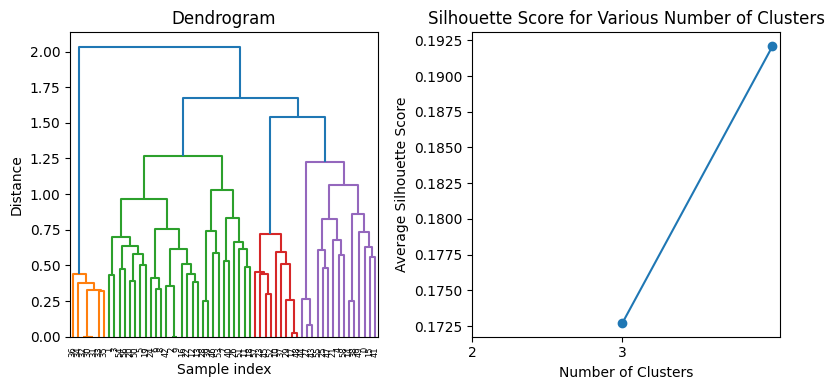

In [88]:
cluster_result = hierarchical_clustering(
    weighted_sum_dataframe, range_min=3, range_max=4
)

In [89]:
cluster_result.head()

,gene,cluster
0,ALOX12,4
1,APLNR,2
2,CD46,2
3,CDH5,2
4,CEACAM5,4


In [90]:
cluster_result.to_csv(weighted_average_output, index=False)

### Simple average

In [91]:
weight = [1, 1, 1]
masks = np.array([~np.isnan(distance_matrix[i].values) for i in range(3)])
valid_weights = np.array([weight[i] for i in range(3)])[:, None, None] * masks
weight_sums = valid_weights.sum(axis=0)
normalized_weights = np.divide(valid_weights, weight_sums, where=weight_sums != 0)
weighted_sum = sum(
    np.nan_to_num(distance_matrix[i].values) * normalized_weights[i] for i in range(3)
)
simple_sum_dataframe = pd.DataFrame(weighted_sum, index=index, columns=index)
simple_sum_dataframe.head()

,ALOX12,APLNR,CD46,CDH5,CEACAM5,CHRNA6,CKLF,CLEC9A,CMTM5,CRISP2,...,SDR9C7,SFRP5,SLC4A1,SOX1,SPAG6,SSTR5,TGM2,TNFRSF9,TP73,XAF1
ALOX12,0.000000,0.534333,0.603333,0.576000,0.534000,0.689000,0.610000,0.576000,0.595667,0.407,...,0.602667,0.469333,0.607333,0.713333,0.639333,0.667000,0.581667,0.637333,0.578000,0.566333
APLNR,0.534333,0.000000,0.314000,0.313667,0.447667,0.375667,0.549667,0.538333,0.525333,0.670,...,0.817667,0.478000,0.468000,0.682667,0.628667,0.358000,0.449333,0.310333,0.587000,0.685667
CD46,0.603333,0.314000,0.000000,0.498000,0.496000,0.549000,0.500000,0.526000,0.492667,0.000,...,0.800000,0.301000,0.606667,0.699333,0.633667,0.555333,0.612667,0.469000,0.585000,0.615667
CDH5,0.576000,0.313667,0.498000,0.000000,0.468333,0.539667,0.543667,0.564000,0.537667,0.531,...,0.789000,0.456333,0.579000,0.610000,0.620333,0.564000,0.522667,0.519333,0.472333,0.580667
CEACAM5,0.534000,0.447667,0.496000,0.468333,0.000000,0.577333,0.461333,0.532333,0.441333,0.197,...,0.801667,0.363333,0.534000,0.694333,0.626667,0.540667,0.619333,0.433333,0.590333,0.552333


Best number of clusters: 4


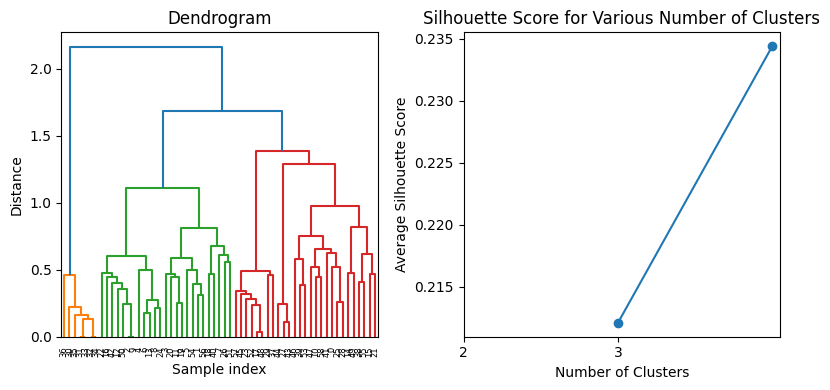

In [92]:
cluster_result = hierarchical_clustering(simple_sum_dataframe, range_min=3, range_max=4)

In [93]:
cluster_result.head()

,gene,cluster
0,ALOX12,4
1,APLNR,2
2,CD46,2
3,CDH5,2
4,CEACAM5,2


In [94]:
cluster_result.to_csv(simple_average_output, index=False)

### Consensus clustering 

Best number of clusters: 10


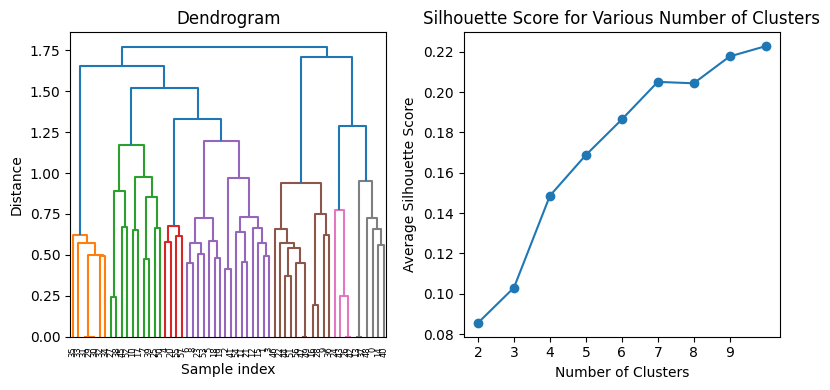

Best number of clusters: 4


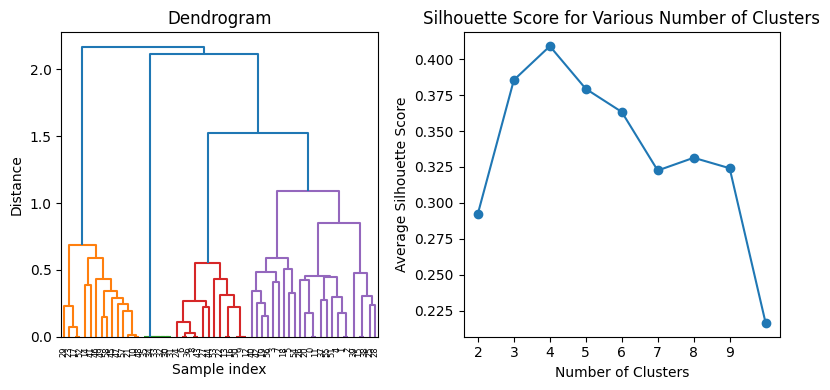

Best number of clusters: 3


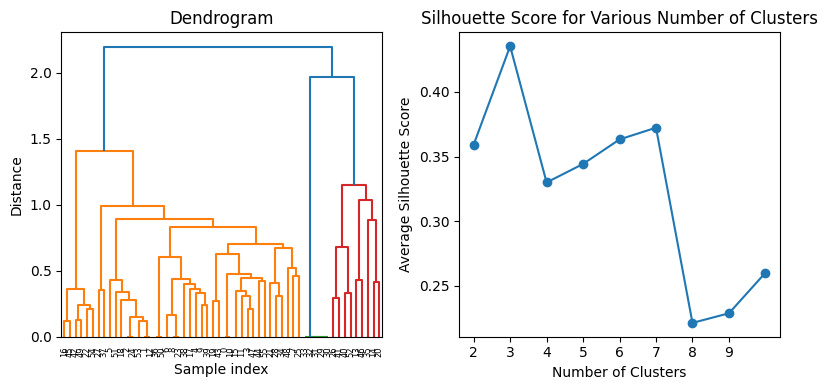

In [95]:
cluster_bp = hierarchical_clustering(distance_matrix_bp)
cluster_cc = hierarchical_clustering(distance_matrix_cc)
cluster_mf = hierarchical_clustering(distance_matrix_mf)

In [96]:
cluster_bp.columns = ["gene", "cluster_bp"]
cluster_cc.columns = ["gene", "cluster_cc"]
cluster_mf.columns = ["gene", "cluster_mf"]
cluster_bp_cc = pd.merge(cluster_bp, cluster_cc, on="gene", how="outer")
cluster_go = pd.merge(cluster_bp_cc, cluster_mf, on="gene", how="outer")
cluster_go = cluster_go.fillna(-1)
print(cluster_go.shape)
cluster_go.head()

(59, 4)


,gene,cluster_bp,cluster_cc,cluster_mf
0,ALOX12,10.0,4,1.0
1,APLNR,7.0,4,1.0
2,CD46,7.0,4,1.0
3,CDH5,7.0,4,1.0
4,CEACAM5,5.0,4,1.0


In [97]:
num_genes = cluster_go.shape[0]

consensus_matrix = np.zeros((num_genes, num_genes))

for i in range(num_genes):


    for j in range(i, num_genes):


        if cluster_go.iloc[i]["cluster_bp"] == cluster_go.iloc[j]["cluster_bp"]:


            consensus_matrix[i][j] += 1

        if cluster_go.iloc[i]["cluster_cc"] == cluster_go.iloc[j]["cluster_cc"]:


            consensus_matrix[i][j] += 1

        if cluster_go.iloc[i]["cluster_mf"] == cluster_go.iloc[j]["cluster_mf"]:


            consensus_matrix[i][j] += 1


consensus_matrix = pd.DataFrame(
    consensus_matrix, index=cluster_go["gene"], columns=cluster_go["gene"]
)
consensus_matrix += consensus_matrix.T


distance_matrix_ = 1 - consensus_matrix / 3
np.fill_diagonal(distance_matrix_.values, 0)


distance_matrix_.head()

gene,ALOX12,APLNR,CD46,CDH5,CEACAM5,CHRNA6,CKLF,CLEC9A,CMTM5,CRISP2,...,SDR9C7,SFRP5,SLC4A1,SOX1,SPAG6,SSTR5,TGM2,TNFRSF9,TP73,XAF1
gene,,,,,,,,,,,,,,,,,,,,,
ALOX12,0.000000,0.333333,0.333333,0.333333,0.333333,0.333333,0.666667,0.333333,0.666667,1.0,...,0.666667,0.666667,0.333333,0.666667,0.666667,0.333333,0.666667,0.333333,0.666667,0.666667
APLNR,0.333333,0.000000,0.000000,0.000000,0.333333,0.333333,0.666667,0.333333,0.666667,1.0,...,1.000000,0.666667,0.333333,0.666667,0.666667,0.333333,0.333333,0.333333,0.666667,0.666667
CD46,0.333333,0.000000,0.000000,0.000000,0.333333,0.333333,0.666667,0.333333,0.666667,1.0,...,1.000000,0.666667,0.333333,0.666667,0.666667,0.333333,0.333333,0.333333,0.666667,0.666667
CDH5,0.333333,0.000000,0.000000,0.000000,0.333333,0.333333,0.666667,0.333333,0.666667,1.0,...,1.000000,0.666667,0.333333,0.666667,0.666667,0.333333,0.333333,0.333333,0.666667,0.666667
CEACAM5,0.333333,0.333333,0.333333,0.333333,0.000000,0.333333,0.666667,0.333333,0.666667,1.0,...,1.000000,0.666667,0.333333,0.666667,0.666667,0.333333,0.666667,0.000000,0.666667,0.333333


Best number of clusters: 10


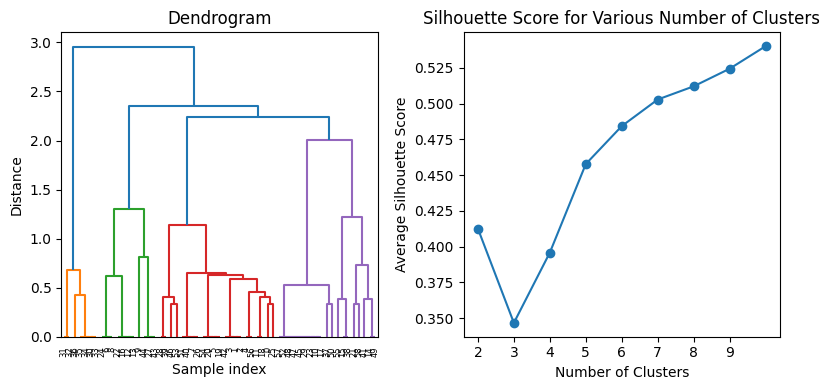

In [98]:
cluster_ = hierarchical_clustering(distance_matrix_)

In [99]:
cluster_result.to_csv(consensus_output, index=False)